## Head

Это решение от авторов курса. 
Комментарии - мои.

## Методика решения
0. В условиях задачи неявно предполагается, что вторая кампания начинается на 250-й день. Для неё и должен быть подготовлен набор участников (таргет-группа). 
1. За основу для решения  можно взять ноутбук занятия 3. Ту его часть, где рассчитывается прямой аплифт. На ту часть, где обсуждается разложение бизнес-задачи на составляющие - внимания не обращаем. 
2. Фичи - это разнообразные агрегаты по покупкам за различные интервалы до начала компании (т.е. до 102-го дня), у авторов это интервалы, 5, 15, 50,  100 дней + возраст клиента + может быть и место проживания  
Важно: обязательно нужна фича "среднее время между покупками"
3. Модель для аплифта предсказывает прибыль за период в 30 дней после кампании, т.е. [102, 102+30], по фичам, расссчитаным за соотв.периоды до начала кампании, т.е до 102-го дня 
4. Предсказания делаются по клиентским фичам, рассчитанных до 250-го дня 
5. Важно: Если для модели causalml брать выборку по всем клиентам, то надо обязательо надо указать значение для параметра p propensity). Если его не указать, то lightGBM не сойдется. Propensity - это фактор, которые учитывает то, что в полной выборке кол-во клиентов в таргет-группе меньше кол-ва клиентов не попавших в таргет-группу, т.е. вероятность попадания в таргет-группу не 50%  

## Открытый вопрос
Не разобрался зачем аторы считают фичи за интервал кампании [102, 102+7], т.к.прибыль считается за 30 дней после начала кампании [102, 102+30]  

## Условия
Прибыль = (
    (
        (Выручка_в_ЦГ - Себестоимость_в_ЦГ) / Размер_ЦГ -
        (Выручка_в_КГ - Себестоимость_в_КГ) / Размер_КГ
    ) * Размер_ЦГ
    - Затраты_на_скидки - Затраты_на_ворон
) * (
    (Размер_ЦГ + Размер_КГ) / Размер_ЦГ
)

Метрики рассчитываются за период в 30 дней с начала действия скидки.

==============================================================================================
Легенда
Сеть магазинов "Хитрый лис" занимается исключительно продажей фисштеха (пряности) в ряде городов (Новиград, Оксенфурт и прочие). Полгода назад "Хитрый лис" провел маркетинговую кампанию. Части клиентов с воронами разослали письма с персональным предложением - "Успейте получить скидку в 40 оренов при первой покупке от одного грамма фисштеха. Скидка действует неделю".

Причем бывший маркетолог "Хитрого лиса" недолго думал и выбрал аудиторию для коммуникации случайным образом.

Перед Вами стоит задача выбрать часть клиентов "Хитрого лиса" так, чтобы суммарная прибыль (определение в разделе оценки) от кампании с подобным предложением была как можно больше.

Решением будет список отобранных клиентов. Контрольную группу выделять не нужно - необходимые процедуры для оценки решения будут проделаны в системе.

В вашем распоряжении информация о продажах за последние 250 дней, базовая информация о покупателях, история запущенных кампаний.


Важно знать:

Цена 1 г фисштеха равна 80 оренам. Себестоимость равна 52 оренам
Отправка одного сообщения вороном стоит 1 орен
У "Хитрого лиса" есть конкурент 😉 - сеть таверн "Семь котов", в которых тоже продают фисштех

In [1]:
import os
import sys
import pandas as pd
import dask.dataframe as dd
import sidetable
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import importlib

In [4]:
from typing import List, Dict, Union

In [5]:
import lightgbm as lgb

In [6]:
import causalml
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.rlearner as rlearner

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Failed to import duecredit due to No module named 'duecredit'


## Lib

In [7]:
import featurelib as fl

In [8]:
def dask_groupby(
    data: dd.DataFrame,
    by: List[str],
    config: Dict[str, Union[str, List[str]]]
) -> dd.DataFrame:
    data_ = data.copy()
    dask_agg_config = dict()

    for col, aggs in config.items():
        aggs = aggs if isinstance(aggs, list) else [aggs]
        for agg in aggs:
            fictious_col = f'{col}_{agg}'
            data_ = data_.assign(**{fictious_col: lambda d: d[col]})
            dask_agg_config[fictious_col] = agg

    result = data_.groupby(by=by).agg(dask_agg_config)
    return result


In [9]:
class ReceiptsBasicFeatureCalcer(fl.DateFeatureCalcer):
    name = 'receipts_basic'
    keys = ['customer_id']

    def __init__(self, delta: int, **kwargs):
        self.delta = delta
        super().__init__(**kwargs)

    def compute(self) -> dd.DataFrame:
        receipts = self.engine.get_table('receipts')
        
        date_from = self.date_to - self.delta
        #print("")
        #print(f"ReceiptsBasicFeatureCalcer.compute: {date_from=}")
        
        date_mask = (receipts['date'] >= date_from) & (receipts['date'] < self.date_to)

        features = receipts.loc[date_mask]
        features = dask_groupby(
            features,
            by=['customer_id'],
            config={
                "purchase_sum": ["sum", "max", "min", "mean"],
                "discount": ["sum"],
                "date": ["min", "max", "count"],
            }
        )
        #print(f"ReceiptsBasicFeatureCalcercompute: after dask_groupby")
        #print(f"ReceiptsBasicFeatureCalcercompute: features.columns = {features.columns}")
        
        # Средний интервал между покупками
        features = (
            features
            .assign(
                mean_time_interval=lambda d: (
                    (d['date_max'] - d['date_min']) / (d['date_count'] - 1)
                )
            )
            .assign(time_since_last=lambda d: self.date_to - d['date_max'])
        )
        #print(f"ReceiptsBasicFeatureCalcercompute: after assign")
        #print(f"ReceiptsBasicFeatureCalcercompute: features.columns = {features.columns}")

        features = features.reset_index()
        #print(f"ReceiptsBasicFeatureCalcercompute: after reset_index")
        #print(f"ReceiptsBasicFeatureCalcercompute: features.columns = {features.columns}")
        
        features = features.rename(columns={
            col: col + f'__{self.delta}d' for col in features.columns if col not in self.keys
        })
        #print(f"ReceiptsBasicFeatureCalcercompute: after rename columns")
        #print(f"ReceiptsBasicFeatureCalcercompute: features.columns = {features.columns}")

        return features

In [10]:
class AgeGeoCalcer(fl.FeatureCalcer):
    name = 'age_geo'
    keys = ['customer_id']

    def compute(self) -> dd.DataFrame:
        customers_info = self.engine.get_table('customers')
        return customers_info[self.keys + ['age', 'location']]

In [11]:
class CampaignInfoCalcer(fl.DateFeatureCalcer):
    name = 'campaigns_info'
    keys = ['customer_id']
    
    def compute(self) -> dd.DataFrame:
        campaigns = self.engine.get_table('campaigns')
        date_mask = campaigns['date'] == self.date_to

        result = (
            self.engine.get_table('campaigns')
            .loc[date_mask]
            [[
                'customer_id',
                'n_offer_days', 'target_group_flag', 'date'
            ]]
            .rename(columns={'date': 'campaign_date'})
        )
        return result


In [12]:
fl.register_calcer(ReceiptsBasicFeatureCalcer)
fl.register_calcer(AgeGeoCalcer)
fl.register_calcer(CampaignInfoCalcer)

## Load'n'cook

In [13]:
engine = fl.Engine(tables={
    'receipts': dd.read_parquet('./data/receipts.parquet'),
    'customers': dd.read_csv('./data/customers.csv'),
    'campaigns': dd.read_csv('./data/campaigns.csv'),
})

### train

#### load

In [14]:
calcers_config = [
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 102, 'delta': 5
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 102, 'delta': 15
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 102, 'delta': 50
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 102, 'delta': 100
        }
    },
    { # target period
        'name': 'receipts_basic',
        'args': {
            'date_to': 132, 'delta': 30
        }
    },
    { # offer period
        'name': 'receipts_basic',
        'args': {
            'date_to': 109, 'delta': 7
        }
    },
    {
        'name': 'age_geo',
        'args': {}
    },
    {
        'name': 'campaigns_info',
        'args': {'date_to': 102}
    }
]

In [15]:
raw_data_train = fl.compute_features(engine, features_config=calcers_config)

In [16]:
raw_data_train = raw_data_train.compute()

In [17]:
raw_data_train.shape

(2000000, 66)

In [18]:
raw_data_train.columns

Index(['customer_id', 'purchase_sum_sum__5d', 'purchase_sum_max__5d',
       'purchase_sum_min__5d', 'purchase_sum_mean__5d', 'discount_sum__5d',
       'date_min__5d', 'date_max__5d', 'date_count__5d',
       'mean_time_interval__5d', 'time_since_last__5d',
       'purchase_sum_sum__15d', 'purchase_sum_max__15d',
       'purchase_sum_min__15d', 'purchase_sum_mean__15d', 'discount_sum__15d',
       'date_min__15d', 'date_max__15d', 'date_count__15d',
       'mean_time_interval__15d', 'time_since_last__15d',
       'purchase_sum_sum__50d', 'purchase_sum_max__50d',
       'purchase_sum_min__50d', 'purchase_sum_mean__50d', 'discount_sum__50d',
       'date_min__50d', 'date_max__50d', 'date_count__50d',
       'mean_time_interval__50d', 'time_since_last__50d',
       'purchase_sum_sum__100d', 'purchase_sum_max__100d',
       'purchase_sum_min__100d', 'purchase_sum_mean__100d',
       'discount_sum__100d', 'date_min__100d', 'date_max__100d',
       'date_count__100d', 'mean_time_interval__1

In [19]:
raw_data_train.head()

,customer_id,purchase_sum_sum__5d,purchase_sum_max__5d,purchase_sum_min__5d,purchase_sum_mean__5d,discount_sum__5d,date_min__5d,date_max__5d,date_count__5d,mean_time_interval__5d,...,date_min__7d,date_max__7d,date_count__7d,mean_time_interval__7d,time_since_last__7d,age,location,n_offer_days,target_group_flag,campaign_date
0,2,3130.691978,2749.047367,381.644612,1565.345989,0.0,97.0,100.0,2.0,3.0,...,NaN,NaN,NaN,NaN,NaN,41,Hindarsfjall,7.0,1.0,102.0
1,18,2784.746810,2784.746810,2784.746810,2784.746810,0.0,97.0,97.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,64,Kaer_Trolde,7.0,1.0,102.0
2,22,943.251812,943.251812,943.251812,943.251812,0.0,97.0,97.0,1.0,NaN,...,105.0,105.0,1.0,NaN,4.0,36,Hindarsfjall,7.0,1.0,102.0
3,52,2480.383924,2480.383924,2480.383924,2480.383924,0.0,97.0,97.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,37,Novigrad,7.0,1.0,102.0
4,55,1483.932263,1483.932263,1483.932263,1483.932263,0.0,97.0,97.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,49,Spikeroog,7.0,1.0,102.0


#### transform

In [20]:
def fix_column_names(data: pd.DataFrame) -> pd.DataFrame:
    for _days in [30, 7]:
        for col_name in [
            f'purchase_sum_sum__{_days}d',
            f'purchase_sum_max__{_days}d',
            f'purchase_sum_min__{_days}d',
            f'purchase_sum_mean__{_days}d',
            f'discount_sum__{_days}d',
            f'date_min__{_days}d',
            f'date_max__{_days}d',
            f'date_count__{_days}d',
            f'mean_time_interval__{_days}d',
            f'time_since_last__{_days}d'
        ]:
            data = data.rename(columns={col_name: 'target__' + col_name})
    return data

In [21]:
MARGIN_RATE = 0.35
MESSAGE_COST = 1.0


def _transform(data: pd.DataFrame) -> pd.DataFrame:
    data.fillna({'target_group_flag': 0}, inplace=True)
    data['target_profit'] = (
        MARGIN_RATE * data['target__purchase_sum_sum__30d'].fillna(0.0)
        - MESSAGE_COST * data['target_group_flag'].fillna(0)
        - data['target__discount_sum__30d'].fillna(0)
    )
    return data

In [22]:
data_train = fix_column_names(raw_data_train)
data_train = _transform(data_train)

In [23]:
data_train.head()

,customer_id,purchase_sum_sum__5d,purchase_sum_max__5d,purchase_sum_min__5d,purchase_sum_mean__5d,discount_sum__5d,date_min__5d,date_max__5d,date_count__5d,mean_time_interval__5d,...,target__date_max__7d,target__date_count__7d,target__mean_time_interval__7d,target__time_since_last__7d,age,location,n_offer_days,target_group_flag,campaign_date,target_profit
0,2,3130.691978,2749.047367,381.644612,1565.345989,0.0,97.0,100.0,2.0,3.0,...,NaN,NaN,NaN,NaN,41,Hindarsfjall,7.0,1.0,102.0,1468.691792
1,18,2784.746810,2784.746810,2784.746810,2784.746810,0.0,97.0,97.0,1.0,NaN,...,NaN,NaN,NaN,NaN,64,Kaer_Trolde,7.0,1.0,102.0,586.967591
2,22,943.251812,943.251812,943.251812,943.251812,0.0,97.0,97.0,1.0,NaN,...,105.0,1.0,NaN,4.0,36,Hindarsfjall,7.0,1.0,102.0,1246.848085
3,52,2480.383924,2480.383924,2480.383924,2480.383924,0.0,97.0,97.0,1.0,NaN,...,NaN,NaN,NaN,NaN,37,Novigrad,7.0,1.0,102.0,1560.986974
4,55,1483.932263,1483.932263,1483.932263,1483.932263,0.0,97.0,97.0,1.0,NaN,...,NaN,NaN,NaN,NaN,49,Spikeroog,7.0,1.0,102.0,569.861415


In [24]:
data_train.columns

Index(['customer_id', 'purchase_sum_sum__5d', 'purchase_sum_max__5d',
       'purchase_sum_min__5d', 'purchase_sum_mean__5d', 'discount_sum__5d',
       'date_min__5d', 'date_max__5d', 'date_count__5d',
       'mean_time_interval__5d', 'time_since_last__5d',
       'purchase_sum_sum__15d', 'purchase_sum_max__15d',
       'purchase_sum_min__15d', 'purchase_sum_mean__15d', 'discount_sum__15d',
       'date_min__15d', 'date_max__15d', 'date_count__15d',
       'mean_time_interval__15d', 'time_since_last__15d',
       'purchase_sum_sum__50d', 'purchase_sum_max__50d',
       'purchase_sum_min__50d', 'purchase_sum_mean__50d', 'discount_sum__50d',
       'date_min__50d', 'date_max__50d', 'date_count__50d',
       'mean_time_interval__50d', 'time_since_last__50d',
       'purchase_sum_sum__100d', 'purchase_sum_max__100d',
       'purchase_sum_min__100d', 'purchase_sum_mean__100d',
       'discount_sum__100d', 'date_min__100d', 'date_max__100d',
       'date_count__100d', 'mean_time_interval__1

#### splits

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
fit_index, val_index = train_test_split(data_train.index, test_size=0.5, random_state=165)

### serve

#### load

In [27]:
calcers_config = [
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 250, 'delta': 5
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 250, 'delta': 15
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 250, 'delta': 50
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 250, 'delta': 100
        }
    },
#     { # target period
#         'name': 'receipts_basic',
#         'args': {
#             'date_to': 132, 'delta': 30
#         }
#     },
#     { # offer period
#         'name': 'receipts_basic',
#         'args': {
#             'date_to': 109, 'delta': 7
#         }
#     },
    {
        'name': 'age_geo',
        'args': {}
    },
#     {
#         'name': 'campaigns_info',
#         'args': {'date_to': 102}
#     }
]

In [28]:
raw_data_serve = fl.compute_features(engine, features_config=calcers_config)

In [29]:
raw_data_serve = raw_data_serve.compute()

In [30]:
raw_data_serve.columns

Index(['customer_id', 'purchase_sum_sum__5d', 'purchase_sum_max__5d',
       'purchase_sum_min__5d', 'purchase_sum_mean__5d', 'discount_sum__5d',
       'date_min__5d', 'date_max__5d', 'date_count__5d',
       'mean_time_interval__5d', 'time_since_last__5d',
       'purchase_sum_sum__15d', 'purchase_sum_max__15d',
       'purchase_sum_min__15d', 'purchase_sum_mean__15d', 'discount_sum__15d',
       'date_min__15d', 'date_max__15d', 'date_count__15d',
       'mean_time_interval__15d', 'time_since_last__15d',
       'purchase_sum_sum__50d', 'purchase_sum_max__50d',
       'purchase_sum_min__50d', 'purchase_sum_mean__50d', 'discount_sum__50d',
       'date_min__50d', 'date_max__50d', 'date_count__50d',
       'mean_time_interval__50d', 'time_since_last__50d',
       'purchase_sum_sum__100d', 'purchase_sum_max__100d',
       'purchase_sum_min__100d', 'purchase_sum_mean__100d',
       'discount_sum__100d', 'date_min__100d', 'date_max__100d',
       'date_count__100d', 'mean_time_interval__1

In [31]:
raw_data_train.columns

Index(['customer_id', 'purchase_sum_sum__5d', 'purchase_sum_max__5d',
       'purchase_sum_min__5d', 'purchase_sum_mean__5d', 'discount_sum__5d',
       'date_min__5d', 'date_max__5d', 'date_count__5d',
       'mean_time_interval__5d', 'time_since_last__5d',
       'purchase_sum_sum__15d', 'purchase_sum_max__15d',
       'purchase_sum_min__15d', 'purchase_sum_mean__15d', 'discount_sum__15d',
       'date_min__15d', 'date_max__15d', 'date_count__15d',
       'mean_time_interval__15d', 'time_since_last__15d',
       'purchase_sum_sum__50d', 'purchase_sum_max__50d',
       'purchase_sum_min__50d', 'purchase_sum_mean__50d', 'discount_sum__50d',
       'date_min__50d', 'date_max__50d', 'date_count__50d',
       'mean_time_interval__50d', 'time_since_last__50d',
       'purchase_sum_sum__100d', 'purchase_sum_max__100d',
       'purchase_sum_min__100d', 'purchase_sum_mean__100d',
       'discount_sum__100d', 'date_min__100d', 'date_max__100d',
       'date_count__100d', 'mean_time_interval__1

In [32]:
raw_data_serve.shape

(2000000, 43)

#### transform

In [33]:
data_serve = fix_column_names(raw_data_serve)

In [34]:
data_serve

,customer_id,purchase_sum_sum__5d,purchase_sum_max__5d,purchase_sum_min__5d,purchase_sum_mean__5d,discount_sum__5d,date_min__5d,date_max__5d,date_count__5d,mean_time_interval__5d,...,purchase_sum_min__100d,purchase_sum_mean__100d,discount_sum__100d,date_min__100d,date_max__100d,date_count__100d,mean_time_interval__100d,time_since_last__100d,age,location
0,1,841.402345,841.402345,841.402345,841.402345,0.0,245.0,245.0,1.0,NaN,...,676.339522,942.989648,0.0,157.0,245.0,5.0,22.000000,5.0,53,Hindarsfjall
1,6,949.027995,949.027995,949.027995,949.027995,0.0,245.0,245.0,1.0,NaN,...,478.944819,919.874613,0.0,158.0,245.0,8.0,12.428571,5.0,57,Hindarsfjall
2,32,1290.046355,1290.046355,1290.046355,1290.046355,0.0,245.0,245.0,1.0,NaN,...,384.712862,1121.586482,0.0,171.0,245.0,5.0,18.500000,5.0,53,Novigrad
3,43,706.528545,416.428582,290.099962,353.264272,0.0,245.0,249.0,2.0,4.0,...,290.099962,599.381424,0.0,170.0,249.0,10.0,8.777778,1.0,31,Crows_perch
4,54,1345.761999,1345.761999,1345.761999,1345.761999,0.0,245.0,245.0,1.0,NaN,...,995.264707,1279.725781,0.0,173.0,245.0,3.0,36.000000,5.0,42,Hindarsfjall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,1999882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,Kaer_Trolde
1999996,1999893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,Kaer_Trolde
1999997,1999904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,Oxenfurt
1999998,1999948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,Beauclair


In [35]:
data_serve.head()

,customer_id,purchase_sum_sum__5d,purchase_sum_max__5d,purchase_sum_min__5d,purchase_sum_mean__5d,discount_sum__5d,date_min__5d,date_max__5d,date_count__5d,mean_time_interval__5d,...,purchase_sum_min__100d,purchase_sum_mean__100d,discount_sum__100d,date_min__100d,date_max__100d,date_count__100d,mean_time_interval__100d,time_since_last__100d,age,location
0,1,841.402345,841.402345,841.402345,841.402345,0.0,245.0,245.0,1.0,NaN,...,676.339522,942.989648,0.0,157.0,245.0,5.0,22.000000,5.0,53,Hindarsfjall
1,6,949.027995,949.027995,949.027995,949.027995,0.0,245.0,245.0,1.0,NaN,...,478.944819,919.874613,0.0,158.0,245.0,8.0,12.428571,5.0,57,Hindarsfjall
2,32,1290.046355,1290.046355,1290.046355,1290.046355,0.0,245.0,245.0,1.0,NaN,...,384.712862,1121.586482,0.0,171.0,245.0,5.0,18.500000,5.0,53,Novigrad
3,43,706.528545,416.428582,290.099962,353.264272,0.0,245.0,249.0,2.0,4.0,...,290.099962,599.381424,0.0,170.0,249.0,10.0,8.777778,1.0,31,Crows_perch
4,54,1345.761999,1345.761999,1345.761999,1345.761999,0.0,245.0,245.0,1.0,NaN,...,995.264707,1279.725781,0.0,173.0,245.0,3.0,36.000000,5.0,42,Hindarsfjall


### column sets

In [36]:
cols_features_n1 = [
    'date_count__100d',
    'purchase_sum_sum__100d',
    'purchase_sum_max__100d',
    'purchase_sum_min__100d',
    'purchase_sum_mean__100d',
    'mean_time_interval__100d',
    'time_since_last__100d',
    'date_count__5d',
    'purchase_sum_sum__5d',
    'purchase_sum_max__5d',
    'purchase_sum_min__5d',
    'purchase_sum_mean__5d',
    'mean_time_interval__5d',
    'age'
]

## Main

### EDA

In [37]:
data_train.loc[fit_index].groupby(by=['target_group_flag']).agg({
    'target_profit': 'mean',
    'target__purchase_sum_sum__30d': 'mean',
    'target__discount_sum__30d': 'mean',
    'customer_id': 'count',
})

,target_profit,target__purchase_sum_sum__30d,target__discount_sum__30d,customer_id
target_group_flag,,,,
0.0,877.410762,3085.212375,0.000000,749414
1.0,875.012598,3080.829310,21.855912,250586


In [38]:
data_train.stb.missing()

,missing,total,percent
mean_time_interval__5d,1970933,2000000,98.54665
target__mean_time_interval__7d,1922763,2000000,96.13815
n_offer_days,1500000,2000000,75.00000
campaign_date,1500000,2000000,75.00000
mean_time_interval__15d,1499398,2000000,74.96990
...,...,...,...
target_group_flag,0,2000000,0.00000
customer_id,0,2000000,0.00000
location,0,2000000,0.00000
age,0,2000000,0.00000


### model

In [39]:
col_target = 'target_profit'
col_treatment = 'target_group_flag'

In [40]:
cols_features = cols_features_n1

In [41]:
model_n1 = rlearner.BaseRRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0,
    n_fold=4,
    random_state=165
)

In [42]:
_p_score_const = data_train.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
_p_scores = pd.Series(data=_p_score_const, index=fit_index)

In [43]:
data_train.loc[fit_index, col_treatment].value_counts()

target_group_flag
0.0    749414
1.0    250586
Name: count, dtype: int64

In [44]:
data_train.loc[fit_index, col_treatment].value_counts().loc[1]

250586

In [45]:
data_train.loc[fit_index, cols_features].head()

,date_count__100d,purchase_sum_sum__100d,purchase_sum_max__100d,purchase_sum_min__100d,purchase_sum_mean__100d,mean_time_interval__100d,time_since_last__100d,date_count__5d,purchase_sum_sum__5d,purchase_sum_max__5d,purchase_sum_min__5d,purchase_sum_mean__5d,mean_time_interval__5d,age
839678,7.0,11852.196209,2431.114226,820.003892,1693.170887,14.666667,12.0,NaN,NaN,NaN,NaN,NaN,NaN,51
318679,13.0,8851.768636,1024.263957,103.006347,680.905280,7.750000,2.0,2.0,1002.020874,899.014526,103.006347,501.010437,1.0,36
1001194,12.0,14934.039836,2135.092251,180.175383,1244.503320,8.000000,10.0,NaN,NaN,NaN,NaN,NaN,NaN,49
15776,5.0,5476.392579,1599.735509,592.201182,1095.278516,22.500000,5.0,1.0,1599.735509,1599.735509,1599.735509,1599.735509,NaN,36
1173764,5.0,2823.362972,900.848067,241.271029,564.672594,21.500000,7.0,NaN,NaN,NaN,NaN,NaN,NaN,20


In [62]:
data_train[cols_features].columns

Index(['date_count__100d', 'purchase_sum_sum__100d', 'purchase_sum_max__100d',
       'purchase_sum_min__100d', 'purchase_sum_mean__100d',
       'mean_time_interval__100d', 'time_since_last__100d', 'date_count__5d',
       'purchase_sum_sum__5d', 'purchase_sum_max__5d', 'purchase_sum_min__5d',
       'purchase_sum_mean__5d', 'mean_time_interval__5d', 'age'],
      dtype='object')

In [46]:
_p_score_const = data_train.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
_p_scores = pd.Series(data=_p_score_const, index=fit_index)
model_n1.fit(
    X=data_train.loc[fit_index, cols_features].fillna(0).values,
    treatment=data_train.loc[fit_index, col_treatment].values,
    y=data_train.loc[fit_index, col_target].values,
    p=_p_scores
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.324578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2483
[LightGBM] [Info] Number of data points in the train set: 1000000, number of used features: 14
[LightGBM] [Info] Start training from score -2.531076


In [47]:
col_target

'target_profit'

#### evaluate model

In [48]:
_eval_data = data_train.loc[val_index, cols_features + [col_treatment, col_target]]
_eval_data['score'] = model_n1.predict(_eval_data[cols_features])
_eval_data = _eval_data[['score', col_treatment, col_target]]

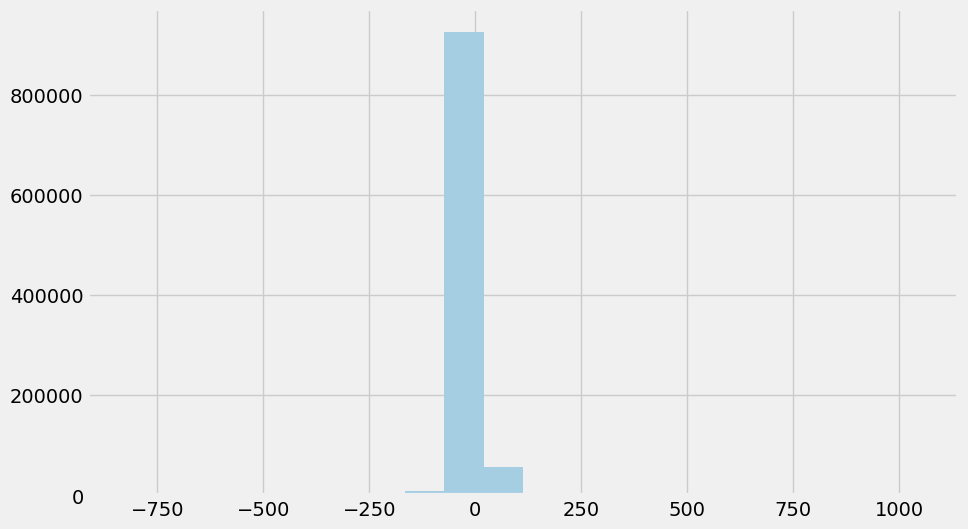

In [49]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], bins=20)
plt.show()

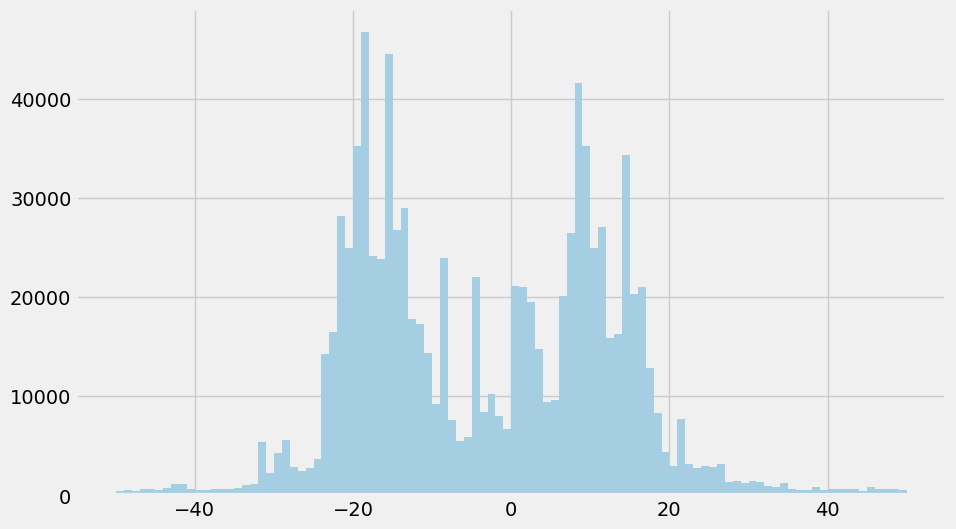

In [50]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], bins=100, range=(-50, 50))
plt.show()

In [51]:
np.percentile(_eval_data['score'], 5)

-27.277112574926004

In [52]:
np.percentile(_eval_data['score'], 95)

23.64571942452336

In [53]:
_eval_data['score'].describe()

count    1000000.000000
mean          -2.600219
std           30.532790
min         -819.318235
25%          -16.991519
50%           -3.586985
75%           10.014556
max         1046.801232
Name: score, dtype: float64

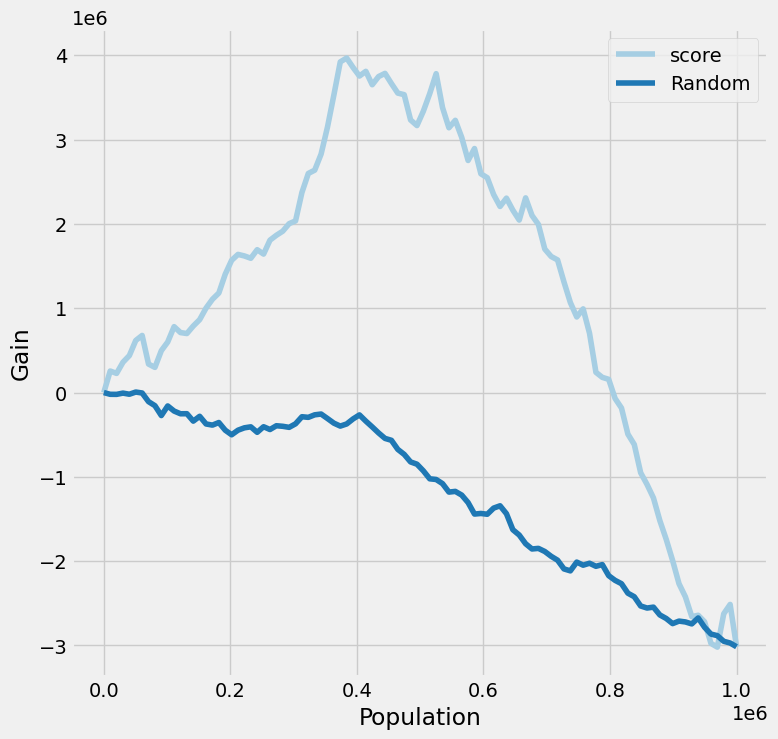

In [54]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

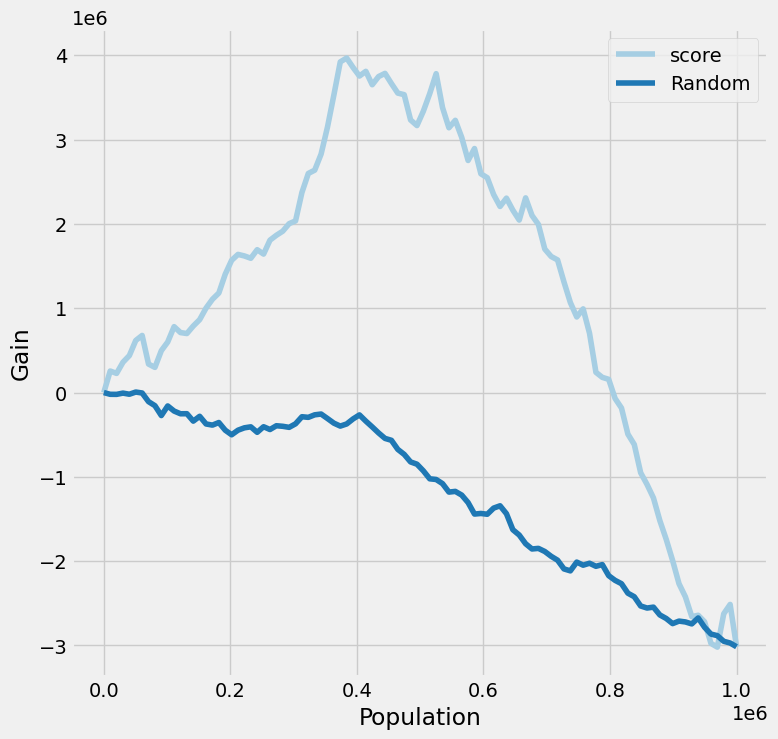

In [55]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

### decisions

In [56]:
data_serve['model_n1_pred'] = model_n1.predict(data_serve[cols_features_n1])

In [57]:
data_serve['model_n1_pred'].describe()

count    2.000000e+06
mean    -2.602779e+00
std      3.080941e+01
min     -9.219294e+02
25%     -1.699151e+01
50%     -3.586985e+00
75%      1.000874e+01
max      1.048260e+03
Name: model_n1_pred, dtype: float64

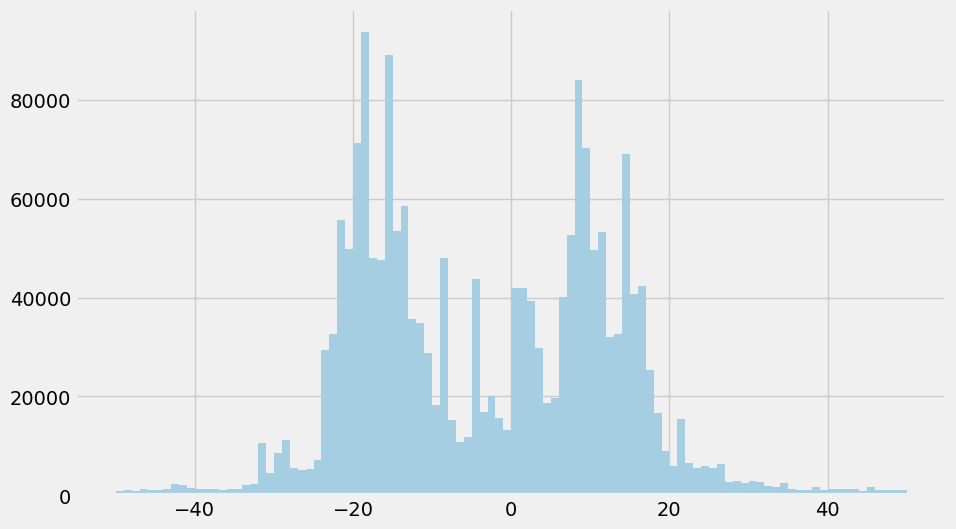

In [58]:
plt.figure(figsize=(10, 6))
plt.hist(data_serve['model_n1_pred'], bins=100, range=(-50, 50))
plt.show()

In [59]:
(data_serve['model_n1_pred'] > 5.0).mean()

0.383612

In [ ]:
#data_serve[data_serve['model_n1_pred'] > 5.0]['customer_id'].to_csv('submission_n1.csv', index=None)